# Assignment 4

**Due to**: TBD

**Credits**: Andrea Galassi, Federico Ruggeri, Paolo Torroni

**Summary**: Fact checking, Neural Languange Inference (**NLI**)

# Intro

This assignment is centred on a particular and emerging NLP task, formally known as **fact checking** (or fake checking). As AI techniques become more and more powerful, reaching amazing results, such as image and text generation, it is more than ever necessary to build tools able to distinguish what is real from what is fake.

Here we focus on a small portion of the whole fact checking problem, which aims to determine whether a given statement (fact) conveys a trustworthy information or not. 

More precisely, given a set of evidences and a fact to verify, we would like our model to correctly predict whether the fact is true or fake.

In particular, we will see:

*   Dataset preparation (analysis and pre-processing)
*   Problem formulation: multi-input binary classification
*   Defining an evaluation method
*   Simple sentence embedding
*   Neural building blocks
*   Neural architecture extension

# The FEVER dataset

First of all, we need to choose a dataset. In this assignment we will rely on the [FEVER dataset](https://fever.ai).

The dataset is about facts taken from Wikipedia documents that have to be verified. In particular, facts could face manual modifications in order to define fake information or to give different formulations of the same concept.

The dataset consists of 185,445 claims manually verified against the introductory sections of Wikipedia pages and classified as ```Supported```, ```Refuted``` or ```NotEnoughInfo```. For the first two classes, systems and annotators need to also return the combination of sentences forming the necessary evidence supporting or refuting the claim.

## Dataset structure

Relevant data is divided into two file types. Information concerning the fact to verify, its verdict and associated supporting/opposing statements are stored in **.jsonl** format. In particular, each JSON element is a python dictionary with the following relevant fields:

*    **ID**: ID associated to the fact to verify.

*    **Verifiable**: whether the fact has been verified or not: ```VERIFIABLE``` or ```NOT VERIFIABLE```.
    
*    **Label**: the final verdict on the fact to verify: ```SUPPORTS```, ```REFUTES``` or ```NOT ENOUGH INFO```.
    
*    **Claim**: the fact to verify.
    
*    **Evidence**: a nested list of document IDs along with the sentence ID that is associated to the fact to verify. In particular, each list element is a tuple of four elements: the first two are internal annotator IDs that can be safely ignored; the third term is the document ID (called URL) and the last one is the sentence number (ID) in the pointed document to consider.

**Some Examples**

---

**Verifiable**

{"id": 202314, "verifiable": "VERIFIABLE", "label": "REFUTES", "claim": "The New Jersey Turnpike has zero shoulders.", "evidence": [[[238335, 240393, "New_Jersey_Turnpike", 15]]]}

---

**Not Verifiable**

{"id": 113501, "verifiable": "NOT VERIFIABLE", "label": "NOT ENOUGH INFO", "claim": "Grease had bad reviews.", "evidence": [[[133128, null, null, null]]]}

---

## Some simplifications and pre-processing

We are only interested in verifiable facts. Thus, we can filter out all non-verifiable claims.

Additionally, the current dataset format does not contain all necessary information for our classification purposes. In particular, we need to download Wikipedia documents and replace reported evidence IDs with the corresponding text.

Don't worry about that! We are providing you the already pre-processed dataset so that you can concentrate on the classification pipeline (pre-processing, model definition, evaluation and training).

You can download the zip file containing all set splits (train, validation and test) of the FEVER dataset by clicking on this [link](https://drive.google.com/file/d/1wArZhF9_SHW17WKNGeLmX-QTYw9Zscl1/view?usp=sharing). Alternatively, run the below code cell to automatically download it on this notebook.

**Note**: each dataset split is in .csv format. Feel free to inspect the whole dataset!

In [ ]:
import os
import requests
import zipfile

def save_response_content(response, destination):
    CHUNK_SIZE = 32768

    with open(destination, "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)

def download_data(data_path):
    toy_data_path = os.path.join(data_path, 'fever_data.zip')
    toy_data_url_id = "1wArZhF9_SHW17WKNGeLmX-QTYw9Zscl1"
    toy_url = "https://docs.google.com/uc?export=download"

    if not os.path.exists(data_path):
        os.makedirs(data_path)

    if not os.path.exists(toy_data_path):
        print("Downloading FEVER data splits...")
        with requests.Session() as current_session:
            response = current_session.get(toy_url,
                                   params={'id': toy_data_url_id},
                                   stream=True)
        save_response_content(response, toy_data_path)
        print("Download completed!")

        print("Extracting dataset...")
        with zipfile.ZipFile(toy_data_path) as loaded_zip:
            loaded_zip.extractall(data_path)
        print("Extraction completed!")

download_data('dataset')

Download completed!
Extracting dataset...
Extraction completed!


# Classification dataset

At this point, you should have a reay-to-go dataset! Note that the dataset format changed as well! In particular, we split the evidence set associated to each claim, in order to build (claim, evidence) pairs. The classification label is propagated as well.

We'll motivate this decision in the next section!

Just for clarity, here's an example of the pre-processed dataset:

---

**Claim**: "Wentworth Miller is yet to make his screenwriting debut."

**Evidence**: "2	He made his screenwriting debut with the 2013 thriller film Stoker .	Stoker	Stoker (film)"

**Label**: Refutes

---

**Note**: The dataset requires some text cleaning as you may notice!


# Problem formulation

As mentioned at the beginning of the assignment, we are going to formulate the fact checking problem as a binary classification task.

In particular, each dataset sample is comprised of:

*     A claim to verify
*     A set of semantically related statements (evidence set)
*     Fact checking label: either evidences support or refute the claim.

Handling the evidence set from the point of view of neural models may imply some additional complexity: if the evidence set is comprised of several sentences we might incur in memory problems.

To this end, we further simplify the problem by building (claim, evidence) pairs. The fact checking label is propagated as well.

Example:

     Claim: c1 
     Evidence set: [e1, e2, e3]
     Label: S (support)

--->

    (c1, e1, S),
    (c1, e2, S),
    (c1, e3, S)

## Schema

The overall binary classification problem is summed up by the following (simplified) schema

![](https://drive.google.com/uc?export=view&id=1Wm_YBnFwgJtxcWEBpPbTBEVkpKaL08Jp)

Don't worry too much about the **Encoding** block for now. We'll give you some simple guidelines about its definition. For the moment, stick to the binary classification task definition where, in this case, we have 2 inputs: the claim to verify and one of its associated evidences.

# Architecture Guidelines

There are many neural architectures that follow the above schema. To avoid phenomena like the writer's block, in this section we are going to give you some implementation guidelines.

In particular, we would like you to test some implementations so that you explore basic approaches (neural baselines) and use them as building blocks for possible extensions.

## Handling multiple inputs

The first thing to notice is that we are in a multi-input scenario. In particular, each sample is comprised of a fact and its asssociated evidence statement.

Each of these input is encoded as a sequence of tokens. In particular, we will have the following input matrices:

*    Claim: [batch_size, max_tokens]
*    Evidence: [batch_size, max_tokens]

Moreover, after the embedding layer, we'll have:

*    Claim: [batch_size, max_tokens, embedding_dim]
*    Evidence: [batch_size, max_tokens, embedding_dim]

But, we would like to have a 2D input to our classifier, since we have to give an answer at pair level. Therefore, for each sample, we would expect the following input shape to our classification block:

*   Classification input shape: [batch_size, dim]

**How to do that?**

We inherently need to reduce the token sequence to a single representation. This operation is formally known as **sentence embedding**. Indeed, we are trying to compress the information of a whole sequence into a single embedding vector.

Here are some simple solutions that we ask you to try out:

*   Encode token sequences via a RNN and take the last state as the sentence embedding.

*   Encode token sequences via a RNN and average all the output states.

*   Encode token sequences via a simple MLP layer. In particular, if your input is a [batch_size, max_tokens, embedding_dim] tensor, the matrix multiplication works on the **max_tokens** dimension, resulting in a [batch_size, embedding_dim] 2D matrix.

*   Compute the sentence embedding as the mean of its token embeddings (**bag of vectors**).

## Merging multi-inputs

At this point, we have to think about **how** we should merge evidence and claim sentence embeddings.

For simplicity, we stick to simple merging strategies:

*     **Concatenation**: define the classification input as the concatenation of evidence and claim sentence embeddings

*     **Sum**: define the classification input as the sum of evidence and claim sentence embeddings

*     **Mean**: define the classification input as the mean of evidence and claim sentence embeddings

For clarity, if we the sentence embedding of a single input has shape [batch_size, embedding_dim], then the classification input has shape:

*     **Concatenation**: [batch_size, 2 * embedding_dim]

*     **Sum**: [batch_size, embedding_dim]

*     **Mean**: [batch_size, embedding_dim]

# A simple extension

Lastly, we ask you to modify previously defined neural architectures by adding an additional feature to the classification input.

We would like to see if some similarity information between the claim to verify and one of its associated evidence might be useful to the classification.

Compute the cosine similarity metric between the two sentence embeddings and concatenate the result to the classification input.

For clarity, since the cosine similarity of two vectors outputs a scalar value, the classification input shape is modified as follows:

*     **Concatenation**: [batch_size, 2 * embedding_dim + 1]

*     **Sum**: [batch_size, embedding_dim + 1]

*     **Mean**: [batch_size, embedding_dim + 1]



# Performance evaluation

Due to our simplifications, obtained results are not directly compatible with a traditional fact checking method that considers the evidence set as a whole.

Thus, we need to consider two types of evaluations.

**Multi-input classification evaluation**

This type of evaluation is the easiest and concerns computing evaluation metrics, such as accuracy, f1-score, recall and precision, of our pre-processed dataset.

In other words, we assess the performance of chosen classifiers.

**Claim verification evaluation**

However, if we want to give an answer concerning the claim itself, we need to consider the whole evidence set. 

Intuitively, for a given claim, we consider all its corresponding (claim, evidence) pairs and their corresponding classification outputs. 

At this point, all we need to do is to compute the final predicted claim label via majority voting.

Example:

    Claim: c1
    Evidence set: e1, e2, e3
    True label: S

    Pair outputs:
    (c1, e1) -> S (supports)
    (c1, e2) -> S (supports)
    (c1, e3) -> R (refutes)

    Majority voting:
    S -> 2 votes
    R -> 1 vote

    Final label:
    c1 -> S

Lastly, we have to compute classification metrics just like before.

# Tips and Extras

## Extensions are welcome!

Is this task too easy for you? Are you curious to try out things you have seen during lectures (e.g. attention)? Feel free to try everything you want!

Don't forget to try neural baselines first!

## Comments and documentation

Remember to properly comment your code (it is not necessary to comment each single line) and don't forget to describe your work!

## Organization

We suggest you to divide your work into sections. This allows you to build clean and modular code, as well as easy to read and to debug.

A possible schema:

*   Dataset pre-processing
*   Dataset conversion
*   Model definition
*   Training
*   Evaluation
*   Comments/Summary

# Contact

For any doubt, question, issue or help, you can always contact us at the following email addresses:

Teaching Assistants:

* Andrea Galassi -> a.galassi@unibo.it
* Federico Ruggeri -> federico.ruggeri6@unibo.it

Professor:

* Paolo Torroni -> p.torroni@unibo.it

Don't forget that your feedback is very important! Your suggestions help us improving course material.

# FAQ

---

**Q: Can I do something text pre-processing?**

**A:** You have to! If you check text data, the majority of sentences need some cleaning.

---

**Q: I'm struggling with the implementation. Can you help me?**

**A:** Yes sure! Write us an email about your issue. If you are looking for a particular type of operation, you can easily check the documentation of the deep learning framework you are using (google is your friend).

---

**Q: Can I try other encoding strategies or neural architectures?**

**A:** Absolutely! Remember to try out recommended neural baselines first and only then proceed with your extensions.

---

# PREPROCESSING

In [ ]:
import pandas as pd
import re
from collections import Counter
from keras.preprocessing.text import Tokenizer
train = pd.read_csv('./dataset/train_pairs.csv')
test = pd.read_csv('./dataset/test_pairs.csv')
val = pd.read_csv('./dataset/val_pairs.csv')
train

,Unnamed: 0,Claim,Evidence,ID,Label
0,0,Chris Hemsworth appeared in A Perfect Getaway.,2\tHemsworth has also appeared in the science ...,3,SUPPORTS
1,1,Roald Dahl is a writer.,0\tRoald Dahl -LRB- -LSB- langpronˈroʊ.əld _ ˈ...,7,SUPPORTS
2,2,Roald Dahl is a governor.,0\tRoald Dahl -LRB- -LSB- langpronˈroʊ.əld _ ˈ...,8,REFUTES
3,3,Ireland has relatively low-lying mountains.,10\tThe island 's geography comprises relative...,9,SUPPORTS
4,4,Ireland does not have relatively low-lying mou...,10\tThe island 's geography comprises relative...,10,REFUTES
...,...,...,...,...,...
121735,121735,April was the month Anderson Silva was born.,0\tAnderson da Silva -LRB- -LSB- ˈɐ̃deʁsõ ˈsiw...,229440,SUPPORTS
121736,121736,Anderson Silva is an American Brazilian mixed ...,0\tAnderson da Silva -LRB- -LSB- ˈɐ̃deʁsõ ˈsiw...,229443,REFUTES
121737,121737,Anderson Silva is incapable of being a Brazili...,0\tAnderson da Silva -LRB- -LSB- ˈɐ̃deʁsõ ˈsiw...,229444,REFUTES
121738,121738,Anderson Silva was born on the month of April ...,0\tAnderson da Silva -LRB- -LSB- ˈɐ̃deʁsõ ˈsiw...,229445,SUPPORTS


In [ ]:
ls = []

def combine_words(input,length):
    combined_inputs = []
    if len(input)>1:
        for i in range(len(input)-1):
            combined_inputs.append(input[i]+" "+last_word_of(input[i+1],length)) #add the last word of the right-neighbour (overlapping) sequence (before it has expanded), which is the next word in the original sentence
    return combined_inputs, length+1

def remove_duplicates(input, length):
    bool_broke=False #this means we didn't find any duplicates here
    for i in range(len(input) - length):
        if input[i]==input[i + length]: #found a duplicate piece of sentence!
            for j in range(0,length): #remove the overlapping sequences in reverse order
                del input[i + length - j]
            bool_broke = True
            break #break the for loop as the loop length does not matches the length of splitted_input anymore as we removed elements
    if bool_broke:
        return remove_duplicates(input, length) #if we found a duplicate, look for another duplicate of the same length
    return input

def last_word_of(input,length):
    splitted = input.split(" ")
    if len(splitted)==0:
        return input
    else:
        return splitted[length-1]

def prepare_evidence(df):
  ls = []
  index = 0
  for x in df['Evidence']:
    i = re.sub(r'^.*?\t', '', x)
    splitted_input = i.replace('-LRB-', '(').replace('-RRB- ', ')').replace('\t', ' ').replace('-LSB-', '').replace('-RSB-', '').split(' ')
    word_length = 1
    splitted_input,word_length = combine_words(splitted_input,word_length)

    intermediate_output = False

    while len(splitted_input)>1:
        splitted_input = remove_duplicates(splitted_input,word_length) #look whether two sequences of length n (with distance n apart) are equal. If so, remove the n overlapping sequences
        splitted_input, word_length = combine_words(splitted_input,word_length) #make even bigger sequences
        if intermediate_output:
            print(splitted_input)
            print(word_length)
    try:
      output = splitted_input[0]
    except:
      output = splitted_input
    index += 1
    ls.append(output)
  return(ls)

train_evidence = prepare_evidence(train)
test_evidence = prepare_evidence(test)
val_evidence = prepare_evidence(val)
print(train_evidence[0], test_evidence[0], val_evidence[0])

Hemsworth has also appeared in the science fiction action film Star Trek ( 2009 ), the thriller adventure A Perfect Getaway ( 2009 ), the horror comedy The Cabin in the Woods ( 2012 ), the dark-fantasy action film Snow White and the Huntsman ( 2012 ), the war film Red Dawn ( 2012 ), and the biographical sports drama film Rush ( 2013 ). Star Trek (film) A Perfect Getaway The Cabin in the Woods Snow White and the Huntsman Red Dawn (2012 film) Rush Rush (2013 film) Furthermore , anxiety has been linked with physical symptoms such as IBS and can heighten other mental health illnesses such as OCD and panic disorder . IBS Irritable bowel syndrome It is an all-volunteer force and comprises more than 80 % of the country 's active defence personnel . all-volunteer force Volunteer military


In [ ]:
X_train = [(train.iloc[x]['Claim'], train_evidence[x]) for x in range(len(train_evidence))]
X_test = [(test.iloc[x]['Claim'], test_evidence[x]) for x in range(len(test_evidence))]
X_val = [(val.iloc[x]['Claim'], val_evidence[x]) for x in range(len(val_evidence))]
X_train[0]

('Chris Hemsworth appeared in A Perfect Getaway.',
 'Hemsworth has also appeared in the science fiction action film Star Trek ( 2009 ), the thriller adventure A Perfect Getaway ( 2009 ), the horror comedy The Cabin in the Woods ( 2012 ), the dark-fantasy action film Snow White and the Huntsman ( 2012 ), the war film Red Dawn ( 2012 ), and the biographical sports drama film Rush ( 2013 ). Star Trek (film) A Perfect Getaway The Cabin in the Woods Snow White and the Huntsman Red Dawn (2012 film) Rush Rush (2013 film)')

In [ ]:
y_train = train['Label']
y_test = test['Label']
y_val = val['Label']

# CONVERSION

In [ ]:
import gensim
import gensim.downloader as gloader
EMBEDDING_SIZE = 200#50
download_path = "glove-wiki-gigaword-{}".format(EMBEDDING_SIZE)
emb_model = gloader.load(download_path)

[==================================================] 100.0% 252.1/252.1MB downloaded


In [ ]:
pos_dict = {}
def create_XY(df):
    X = [] # store input sequence
    pos = 0
    max_len = 0
    for sentence in df:
      X_sentence = []
      try:
        for word in sentence.split(' '):
          if len(sentence) > max_len:
            max_len = len(sentence)
          X_sentence.append(word)
      except:
          X_sentence.append('')
      X.append(X_sentence)
    num_words = len(set([word.lower() for sentence in X for word in sentence]))
    print("Total number of tagged sentences: {}".format(len(X)))
    print("Vocabulary size: {}".format(num_words))
    print('sample X: ', X[0], '\n')
    print("Length of first input sequence  : {}".format(len(X[0])))
    print("Maximum length of sentence : {}".format(max_len))
    return X, num_words, max_len


In [ ]:
X_train_claim, num_words_train_claim, MAX_LEN_TRAIN_claim = create_XY(train['Claim'])
X_val_claim, num_words_val_claim, MAX_LEN_VAL_claim = create_XY(val['Claim'])
X_test_claim, num_words_test_claim, MAX_LEN_TEST_claim= create_XY(test['Claim'])

X_train_evidence, num_words_train_evidence, MAX_LEN_TRAIN_evidence = create_XY(train_evidence)
X_val_evidence, num_words_val_evidence, MAX_LEN_VAL_evidence = create_XY(val_evidence)
X_test_evidence, num_words_test_evidence, MAX_LEN_TEST_evidence = create_XY(test_evidence)

Total number of tagged sentences: 121740
Vocabulary size: 31186
sample X:  ['Chris', 'Hemsworth', 'appeared', 'in', 'A', 'Perfect', 'Getaway.'] 

Length of first input sequence  : 7
Maximum length of sentence : 614
Total number of tagged sentences: 7165
Vocabulary size: 6619
sample X:  ['The', 'Indian', 'Army', 'comprises', 'part', 'of', 'the', "country's", 'active', 'defense', 'personnel.'] 

Length of first input sequence  : 11
Maximum length of sentence : 200
Total number of tagged sentences: 7189
Vocabulary size: 7141
sample X:  ['Anxiety', 'has', 'been', 'linked', 'with', 'physical', 'symptoms.'] 

Length of first input sequence  : 7
Maximum length of sentence : 189
Total number of tagged sentences: 121740
Vocabulary size: 36238
sample X:  ['Hemsworth', 'has', 'also', 'appeared', 'in', 'the', 'science', 'fiction', 'action', 'film', 'Star', 'Trek', '(', '2009', '),', 'the', 'thriller', 'adventure', 'A', 'Perfect', 'Getaway', '(', '2009', '),', 'the', 'horror', 'comedy', 'The', 'Cab

In [ ]:
words, tags = set([]), set([])
X_train = X_train_claim + X_train_evidence
 
for s in X_train:
    for w in s:
       words.add(w.lower())
 
word2index = {w: i + 1 for i, w in enumerate(list(words))}
word2index['-PAD-'] = 0  # The special value used for padding

In [ ]:
words_test, tags_test = set([]), set([])
X_test = X_test_claim + X_test_evidence

for s in X_test:
    for w in s:
       words_test.add(w.lower())
 
word2indexTest = {w: i + 2 for i, w in enumerate(list(words_test))}
word2indexTest['-PAD-'] = 0  # The special value used for padding

In [ ]:
words_val, tags_val = set([]), set([])
X_val = X_val_claim + X_val_evidence

for s in X_val:
    for w in s:
       words_val.add(w.lower())
 
word2indexVal = {w: i + 2 for i, w in enumerate(list(words_val))}
word2indexVal['-PAD-'] = 0  # The special value used for padding

## Merging indexes and padding

In [ ]:
def merge_word2indexes(word2index, word2indexTest, word2indexVal): 
  for x in word2indexVal:
    if x not in word2index.keys():
      word2index[x] = len(word2index) 
  for x in word2indexTest:
    if x not in word2index.keys():
      word2index[x] = len(word2index) 
  return word2index
word2index = merge_word2indexes(word2index, word2indexTest, word2indexVal)

In [ ]:
train_sentences_X_claim, test_sentences_X_claim, val_sentences_X_claim = [], [], []
train_sentences_X_evidence, test_sentences_X_evidence, val_sentences_X_evidence = [], [], []

oov = [] 

for s in X_train_claim:
    s_int = []
    for w in s:
        s_int.append(word2index[w.lower()])
    train_sentences_X_claim.append(s_int)

for s in X_train_evidence:
    s_int = []
    for w in s:
        s_int.append(word2index[w.lower()])
    train_sentences_X_evidence.append(s_int)

for s in X_test_claim:
    s_int = []
    for w in s:
        s_int.append(word2index[w.lower()])
    test_sentences_X_claim.append(s_int)

for s in X_test_evidence:
    s_int = []
    for w in s:
        s_int.append(word2index[w.lower()])
    test_sentences_X_evidence.append(s_int)

for s in X_val_claim:
    s_int = []
    for w in s:
        s_int.append(word2index[w.lower()])
    val_sentences_X_claim.append(s_int)

for s in X_val_evidence:
    s_int = []
    for w in s:
        s_int.append(word2index[w.lower()])
    val_sentences_X_evidence.append(s_int)
 
print(train_sentences_X_claim[0])
print(test_sentences_X_claim[0])
print(val_sentences_X_claim[0])
print(train_sentences_X_evidence[0])
print(test_sentences_X_evidence[0])
print(val_sentences_X_evidence[0])

[11211, 15982, 32868, 17831, 45706, 26466, 17880]
[14897, 23772, 31595, 4828, 51896, 28011, 9492]
[24031, 1323, 34099, 33077, 35212, 23892, 24031, 52571, 31809, 3905, 53164]
[15982, 23772, 32854, 32868, 17831, 24031, 34675, 5327, 36694, 9863, 26863, 22859, 17507, 19897, 496, 24031, 595, 22368, 45706, 26466, 46709, 17507, 19897, 496, 24031, 5457, 50496, 24031, 2673, 17831, 24031, 751, 17507, 20192, 496, 24031, 50051, 36694, 9863, 21954, 16794, 48367, 24031, 18424, 17507, 20192, 496, 24031, 15514, 9863, 3939, 42234, 17507, 20192, 496, 48367, 24031, 50149, 21371, 44110, 9863, 34006, 17507, 6813, 13674, 26863, 22859, 14752, 45706, 26466, 46709, 24031, 2673, 17831, 24031, 751, 21954, 16794, 48367, 24031, 18424, 3939, 42234, 5264, 841, 34006, 34006, 47810, 841]
[46296, 46728, 14897, 23772, 31595, 4828, 51896, 28011, 34382, 35130, 36748, 57504, 48367, 7682, 57849, 4029, 52034, 8281, 28543, 35130, 36748, 56875, 48367, 39686, 23882, 11419, 57504, 56622, 7712, 23792]
[33696, 48763, 48288, 54821,

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

Length of longest document: 152 words


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


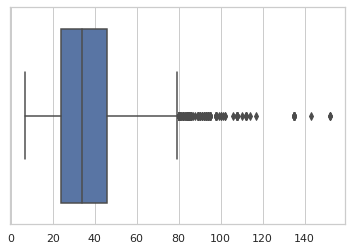

In [ ]:
def compute_document_length(X):
  """
  Calculate length of documents of current split X.

  :param X: current split to analyze

  :return
      - vector of lengths
  """
  lengths = [len(seq) for seq in X]
  print("Length of longest document: {} words".format(max(lengths)))
  return lengths

length_train = compute_document_length(test_sentences_X_evidence)
sns.set_theme(style="whitegrid")
sns.boxplot(length_train)
plt.show()

In [ ]:
from keras.preprocessing.sequence import pad_sequences

MAX_LEN_TRAIN_claim = 65
MAX_LEN_VAL_claim = 65#31
MAX_LEN_TEST_claim = 65#31

MAX_LEN_TRAIN_evidence = 203
MAX_LEN_VAL_evidence = 203#168
MAX_LEN_TEST_evidence = 203#152

train_sentences_X_claim = pad_sequences(train_sentences_X_claim, maxlen=MAX_LEN_TRAIN_claim, padding='post', truncating='post')
val_sentences_X_claim = pad_sequences(val_sentences_X_claim, maxlen=MAX_LEN_VAL_claim, padding='post', truncating='post')
test_sentences_X_claim = pad_sequences(test_sentences_X_claim, maxlen=MAX_LEN_TEST_claim, padding='post', truncating='post')

train_sentences_X_evidence = pad_sequences(train_sentences_X_evidence, maxlen=MAX_LEN_TRAIN_evidence, padding='post', truncating='post')
val_sentences_X_evidence = pad_sequences(val_sentences_X_evidence, maxlen=MAX_LEN_VAL_evidence, padding='post', truncating='post')
test_sentences_X_evidence = pad_sequences(test_sentences_X_evidence, maxlen=MAX_LEN_TEST_evidence, padding='post', truncating='post')

In [ ]:
def get_embedding_bounds(embedding_model):
  """
  Get minimum and maximum values for embedding, to use during the generation of random embeddings for OOV terms

  :param embedding_model: pre-trained word embedding model (gensim wrapper)

  :return
      - maximum value found in embedding vectors
      - minimum value found in embedding vectors
  """

  lb, ub = 0, 0
  for word in list(embedding_model.vocab.keys()):
      minimum = np.min(embedding_model.get_vector(word))
      if minimum < lb: lb = minimum
      maximum = np.max(embedding_model.get_vector(word))
      if maximum > ub: ub = maximum

  return ub, lb

In [ ]:
import numpy as np
weights = np.zeros((len(word2index.keys()), EMBEDDING_SIZE))
word_list = list(word2index.keys())

ub, lb = get_embedding_bounds(emb_model)

oov = {}
for x in range(len(word_list)):
  try: 
    weights[x, :] = emb_model[word_list[x]]
  except:
    oov[word_list[x]] = x
    weights[x, :] = np.random.uniform(low=lb, high=ub, size=EMBEDDING_SIZE)
    #np.random.rand(EMBEDDING_SIZE)

# MODEL

In [ ]:
import tensorflow as tf
from keras.layers import Add, Average, Dense, Input, GlobalMaxPooling1D, Dot, LSTM, Bidirectional, \
Dropout, Embedding, concatenate, Concatenate, GlobalAveragePooling1D, AdditiveAttention
from keras.models import Model
from keras.optimizers import SGD
import tensorflow.keras as keras

In [ ]:
!pip install transformers

In [ ]:
import os
import re
import json
import string
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from transformers import BertTokenizer, TFBertModel, BertConfig

max_len = 384
configuration = BertConfig()  # default parameters and configuration for BERT
configuration.vocab_size = VOCAB_SIZE
configuration.hidden_size = 64
configuration.intermediate_size = 64
configuration.num_attention_heads = 1
configuration.num_hidden_layers = 1
configuration.max_position_embeddings = MAX_LEN_TRAIN_evidence

In [ ]:
VOCAB_SIZE = len(word2index)
BATCH_SIZE = 64
EMBEDDING_DIM = EMBEDDING_SIZE
UNITS = 512

In [ ]:
claim_input = Input(shape=(MAX_LEN_TRAIN_claim), name='claim_input')
evidence_input = Input(shape=(MAX_LEN_TRAIN_evidence), name='evidence_input')

embedding_layer = Embedding(input_dim=VOCAB_SIZE, output_dim=EMBEDDING_DIM,  weights=[weights], mask_zero=True, trainable=False)

claim_outputs = embedding_layer(claim_input)
evidence_outputs = embedding_layer(evidence_input)

## Reduce the token sequence to a single representation

### RNN taking last hidden state

In [ ]:
def last_state_model():  
  claim_outputs1, claim_forward_h, _, claim_backward_h, _ = Bidirectional(LSTM(UNITS, return_sequences=True, return_state=True))(claim_outputs)
  claim_outputs1 = Concatenate()([claim_forward_h, claim_backward_h])

  evidence_outputs1, evidence_forward_h, _, evidence_backward_h, _ = Bidirectional(LSTM(UNITS, return_sequences=True, return_state=True))(evidence_outputs)
  evidence_outputs1 = Concatenate()([evidence_forward_h, evidence_backward_h])
  return claim_outputs1, evidence_outputs1

### RNN averaging all states

In [ ]:
def avg_model():  
  claim_outputs2 = Bidirectional(LSTM(UNITS*2, return_sequences=True))(claim_outputs)
  evidence_outputs2 = Bidirectional(LSTM(UNITS*2, return_sequences=True))(evidence_outputs)

  claim_outputs2 = GlobalAveragePooling1D()(claim_outputs2)
  evidence_outputs2 = GlobalAveragePooling1D()(evidence_outputs2)
  return claim_outputs2, evidence_outputs2

### Using MLP layer

In [ ]:
class Linear(keras.layers.Layer):
    def __init__(self, units=32):
        super(Linear, self).__init__()
        self.units = units

    def build(self, input_shape):
        self.w = self.add_weight(
            shape=(input_shape[-1], self.units),
            initializer="random_normal",
            trainable=True,
        )
        self.b = self.add_weight(
            shape=(self.units,), initializer="random_normal", trainable=True
        )

    def call(self, inputs):
        return tf.matmul(inputs, self.w) + self.b

In [ ]:
class MLPBlock(keras.layers.Layer):
    def __init__(self):
        super(MLPBlock, self).__init__()
        self.maxpool = GlobalMaxPooling1D()
        self.linear_1 = Linear(512)
        self.linear_2 = Linear(256)
        self.linear_3 = Linear(64)
        self.dropout = Dropout(0.1)

    def call(self, inputs):
        x = self.maxpool(inputs)
        x = self.linear_1(x)
        x = tf.nn.relu(x)
        x = self.dropout(x)
        x = self.linear_2(x)
        x = tf.nn.relu(x)
        x = self.dropout(x)
        return self.linear_3(x)

In [ ]:
def mlp_model():  
  mlp = MLPBlock()
  claim_outputs3 = mlp(claim_outputs)
  evidence_outputs3 = mlp(evidence_outputs)
  return claim_outputs3, evidence_outputs3

### Using BoW

In [ ]:
import keras.layers as L
import keras.backend as K

class NonZeroMean(L.Layer):
  def call(self, x): 
    """Calculate non-zero mean."""
    # count the number of nonzero features on embedding axis
    nonzero = K.any(K.not_equal(x, 0.0), axis=-1)
    n = K.sum(K.cast(nonzero, 'float32'), axis=-1, keepdims=True)
    # average on max_tokens axis
    x_mean = K.sum(x, axis=-2) / n
    return x_mean

  def compute_output_shape(self, input_shape):
    """Collapse summation axis."""
    return input_shape[:-2] + (input_shape[-1],)

In [ ]:
def bow_model():
  claim_outputs4 = NonZeroMean()(claim_outputs)
  evidence_outputs4 = NonZeroMean()(evidence_outputs)
  return claim_outputs4, evidence_outputs4

## Final part of the model

In [ ]:
def concat_model(claim_model, evidence_model):
  claim = Dropout(0.2)(claim_model.output)
  evidence = Dropout(0.2)(evidence_model.output)

  combined = Dense(128, activation='relu')(combined)
  combined = Dense(64, activation='relu')(combined)
  z = Dense(1, activation='sigmoid')(combined)
  return z

In [ ]:
def concat_model_w_similarity(claim_model, evidence_model):
  claim = Dropout(0.2)(claim_model.output)
  evidence = Dropout(0.2)(evidence_model.output)
  combined = concatenate([claim, evidence, sentence_similarity], name='combined_output')

  combined = Dense(128, activation='relu')(combined)
  combined = Dense(64, activation='relu')(combined)
  z = Dense(1, activation='sigmoid')(combined)
  return z

In [ ]:
def sum_model(claim_model, evidence_model):
  claim = Dropout(0.2)(claim_model.output)
  evidence = Dropout(0.2)(evidence_model.output)
  combined = Add()([claim, evidence])

  combined = Dense(128, activation='relu')(combined)
  combined = Dense(64, activation='relu')(combined)
  z = Dense(1, activation='sigmoid')(combined)
  return z

In [ ]:
def mean_model(claim_model, evidence_model):
  claim = Dropout(0.2)(claim_model.output)
  evidence = Dropout(0.2)(evidence_model.output)
  combined = Average()([claim, evidence])

  combined = Dense(128, activation='relu')(combined)
  combined = Dense(64, activation='relu')(combined)
  combined = Dense(2, activation='relu')(combined)
  z = Dense(1, activation='sigmoid')(combined)
  return z

In [ ]:
# encode class values as integers
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

encoder = LabelEncoder()
encoder.fit(y_train)

encoded_Y_train = encoder.transform(y_train)
encoded_Y_val = encoder.transform(y_val)
encoded_Y_test = encoder.transform(y_test)

# TRAINING

In [ ]:
encoder = TFBertModel(config=configuration)

claim_outputs = encoder(claim_input)[0]
evidence_outputs = encoder(evidence_input)[0]

In [ ]:
# Training for all 4 models with a common merging strategy (mean)

model = {0:'LAST STATE', 1:'AVG STATES', 2:'MLP', 3:'BoW'}
multi = {0:'MEAN'}

for x in range(model):
  if x == 0:
    print('LAST STATE')
    claim_outputs_fin, evidence_outputs_fin = last_state_model()
  elif x == 1:
    print('AVG STATES')
    claim_outputs_fin, evidence_outputs_fin = avg_model()
  elif x == 2:
    print('MLP')
    claim_outputs_fin, evidence_outputs_fin = mlp_model()
  elif x == 3:
    print('BoW')
    claim_outputs_fin, evidence_outputs_fin = bow_model()

  claim_model = Model(inputs=claim_input, outputs=claim_outputs_fin)
  evidence_model = Model(inputs=evidence_input, outputs=evidence_outputs_fin)

  print('MEAN')
  z = mean_model(claim_model, evidence_model)

  model = Model(inputs=[claim_model.input, evidence_model.input], outputs=z)
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  model.summary()
  model.fit([train_sentences_X_claim, train_sentences_X_evidence], encoded_Y_train, batch_size=128, epochs=5, validation_data=([val_sentences_X_claim, val_sentences_X_evidence], encoded_Y_val))
  model.evaluate([val_sentences_X_claim, val_sentences_X_evidence], encoded_Y_val)
  
  y_pred = model.predict([val_sentences_X_claim, val_sentences_X_evidence])
  print(classification_report(encoded_Y_val, np.round(y_val)))

In [ ]:
# Training of a single model with all 3 merging strategies

multi = {0:'CONCATENATE', 1:'SUM', 2:'MEAN'}

for y in range(multi):
  claim_outputs_fin, evidence_outputs_fin = last_state_model()

  claim_model = Model(inputs=claim_input, outputs=claim_outputs_fin)
  evidence_model = Model(inputs=evidence_input, outputs=evidence_outputs_fin)

  if y == 0:
    print('CONCATENATE')
    z = concat_model(claim_model, evidence_model)
  elif y == 1:
    print('SUM')
    z = sum_model(claim_model, evidence_model)
  elif y == 2:
    print('MEAN')
    z = mean_model(claim_model, evidence_model)

  model = Model(inputs=[claim_model.input, evidence_model.input], outputs=z)
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  model.summary()
  model.fit([train_sentences_X_claim, train_sentences_X_evidence], encoded_Y_train, batch_size=128, epochs=5, validation_data=([val_sentences_X_claim, val_sentences_X_evidence], encoded_Y_val))
  model.evaluate([val_sentences_X_claim, val_sentences_X_evidence], encoded_Y_val)
  
  y_pred = model.predict([val_sentences_X_claim, val_sentences_X_evidence])
  print(classification_report(encoded_Y_val, np.round(y_val)))

In [ ]:
# Training of a model and a strategy with the optional cosine similarity feature

print('LAST HIDDEN STATES MODEL CONCATENATED WITH COSINE SIMILARITY')
claim_outputs_fin, evidence_outputs_fin = last_state_model()

claim_model = Model(inputs=claim_input, outputs=claim_outputs_fin)
evidence_model = Model(inputs=evidence_input, outputs=evidence_outputs_fin)

sentence_similarity = Dot(axes=1)([claim_model.output, evidence_model.output]) 

z = concat_model_w_similarity(claim_model, evidence_model)

model = Model(inputs=[claim_model.input, evidence_model.input], outputs=z)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()
model.fit([train_sentences_X_claim, train_sentences_X_evidence], encoded_Y_train, batch_size=128, epochs=5, validation_data=([val_sentences_X_claim, val_sentences_X_evidence], encoded_Y_val))
model.evaluate([val_sentences_X_claim, val_sentences_X_evidence], encoded_Y_val)

y_pred = model.predict([val_sentences_X_claim, val_sentences_X_evidence])
print(classification_report(encoded_Y_val, np.round(y_pred)))

# EVALUATION

### Majority voting evaluation (no sensible improvements)

In [ ]:
from collections import defaultdict

def list_duplicates(seq):
    tally = defaultdict(list)
    for i,item in enumerate(seq):
        tally[item].append(i)
    return (locs for _, locs in tally.items() if len(locs)>1)

def majority_voting_evaluation(split, encoded_labels, predictions):
    ids = split['ID'].values
    duplicates_indices = [dup for dup in sorted(list_duplicates(ids))]

    # list of indexes of duplicates to delete
    flattened = [val for sublist in duplicates_indices for val in sublist[1:]]

    for dup in duplicates_indices:
        curr_labels = []
        for d in dup:
            curr_labels.append(predictions[d])
            # Majority voting algorithm
            candidate = 0
            count = 0
            for value in curr_labels:
              if count == 0:
                candidate = value
              if candidate == value:
                count += 1
              else:
                count -= 1
            voted_label = candidate
            predictions[dup[0]] = voted_label

    real_labels = np.delete(encoded_labels, flattened) # delete labels of duplicates
    predictions = np.delete(predictions, flattened)

    return real_labels, predictions

In [ ]:
y_true, y_predicted = majority_voting_evaluation(val, encoded_Y_val, y_pred)
print(classification_report(y_true, np.round(y_predicted)))

              precision    recall  f1-score   support

           0       0.83      0.53      0.64      3308
           1       0.65      0.89      0.75      3304

    accuracy                           0.71      6612
   macro avg       0.74      0.71      0.70      6612
weighted avg       0.74      0.71      0.70      6612



# COMMENTARY